# Bodo Extended Tutorial

This is a continuation of the ["Getting Started"](https://docs.bodo.ai/installation_and_setup/ipyparallel/?h=getting+started) tutorial. You are encouraged to visit that tutorial first if you have not done so already. In this tutorial, we will explain core Bodo concepts in more detail, introduce additional Bodo features, and discuss more advanced topics.

## Environment Setup
Please follow the [Bodo installation](https://docs.bodo.ai/installation_and_setup/install/) and [Jupyter Notebook Setup](https://docs.bodo.ai/2022.6/installation_and_setup/ipyparallel/#testinstall) pages to setup the environment.

### Parallel Execution Model

As we saw in the "Getting Started" tutorial, Bodo transforms functions for parallel execution. However, the dispatcher does not launch processes or threads on the fly. Instead, the Python application (including non-Bodo code) is intended to be executed under an MPI Single Program Multiple Data ([SPMD](https://en.wikipedia.org/wiki/SPMD)) paradigm, where MPI processes are launched in the beginning and all run the same code.


For example, we can save an example code in a file and use *mpiexec* to launch 8 processes:

In [1]:
import numpy as np
import pandas as pd
import bodo

@bodo.jit()
def f(n, a):
    df = pd.DataFrame({"A": np.arange(n) + a})
    return df

print(f(16, 1))

     A
0    1
1    2
2    3
3    4
4    5
5    6
6    7
7    8
8    9
9   10
10  11
11  12
12  13
13  14
14  15
15  16


In [2]:
%save -f test_bodo.py 1 # cell number of previous cell

The following commands were written to file `test_bodo.py`:
import numpy as np
import pandas as pd
import bodo

@bodo.jit()
def f(n, a):
    df = pd.DataFrame({"A": np.arange(n) + a})
    return df

print(f(16, 1))


In [3]:
!mpiexec -n 8 python test_bodo.py

    A
8   9
9  10
   A
2  3
3  4
   A
0  1
1  2
   A
6  7
7  8
   A
4  5
5  6
     A
10  11
11  12
     A
12  13
13  14
     A
14  15
15  16


In this example, `mpiexec` launches 8 Python processes, each of which executes the same `test_bodo.py` file.

<div class="alert alert-block alert-warning"
<b>Important:</b>

- Python codes outside of Bodo functions execute sequentially on every process.
- Bodo functions run in parallel assuming that Bodo is able to parallelize them. Otherwise, they also run sequentially on every process. Bodo warns if it does not find parallelism (more details later).

</div>

Note how the prints, which are regular Python code executed outside of Bodo, run for each process.

On Jupyter notebook, parallel execution happens in very much the same way. We start a set of MPI engines through `ipyparallel` and activate a client (*NOTE: if you are using the Bodo Platform, this is done automatically*):

In [1]:
import os
if os.environ.get("BODO_PLATFORM_WORKSPACE_UUID",'NA') == 'NA':
    print("You are not on Bodo Platform, running ipyparallel.. ")
    import ipyparallel as ipp
    import psutil; n = min(psutil.cpu_count(logical=False), 8)
    rc = ipp.Cluster(engines='mpi', n=n).start_and_connect_sync(activate=True)

You are not on Bodo Platform, running ipyparallel.. 
Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:06<00:00,  1.32engine/s]


Again, if your machine has less then 8 cores, the code will run on that number of cores. After this initialization, any code that we run in the notebook with `%%px` is sent for execution on all MPI engines.

In [5]:
%%px

import numpy as np
import pandas as pd
import bodo

@bodo.jit()
def f(n):
    df = pd.DataFrame({"A": np.arange(n)})
    return df

print(f(16))

[stdout:2] 
   A
4  4
5  5
[stdout:6] 
     A
12  12
13  13
[stdout:1] 
   A
2  2
3  3
[stdout:0] 
   A
0  0
1  1
[stdout:4] 
   A
8  8
9  9
[stdout:5] 
     A
10  10
11  11
[stdout:3] 
   A
6  6
7  7
[stdout:7] 
     A
14  14
15  15


For the sake of this tutorial, when running code on the full 8 cores, we limit the number of rows printed to standard out to reduce clutter.

In [6]:
%%px
pd.options.display.max_rows = 3

### Parallel APIs

Bodo provides a limited number of parallel APIs to support advanced cases that may need them. The example below demonstrates getting the process number from Bodo (called `rank` in MPI terminology) and the total number of processes.

In [7]:
%%px

# some work only on rank 0
if bodo.get_rank() == 0:
    print("rank 0 done")

# some work on every process
print("rank", bodo.get_rank(), "here")
print("total ranks:", bodo.get_size())

[stdout:0] 
rank 0 done
rank 0 here
total ranks: 8
[stdout:1] 
rank 1 here
total ranks: 8
[stdout:6] 
rank 6 here
total ranks: 8
[stdout:5] 
rank 5 here
total ranks: 8
[stdout:2] 
rank 2 here
total ranks: 8
[stdout:3] 
rank 3 here
total ranks: 8
[stdout:4] 
rank 4 here
total ranks: 8
[stdout:7] 
rank 7 here
total ranks: 8


A common pattern is using barriers to make sure all processes see side-effects at the same time. For example, a process can delete files from storage while others wait before writing to file:

In [8]:
%%px
import shutil, os
import numpy as np

# remove file if exists
if bodo.get_rank() == 0:
    if os.path.exists("data/data.pq"):
        shutil.rmtree("data/data.pq")

# make sure all processes are synchronized
# (e.g. all processes need to see effect of rank 0's work)
bodo.barrier()

@bodo.jit
def f(n):
    df = pd.DataFrame({"A": np.arange(n)})
    df.to_parquet("data/data.pq")

f(10)

The following figure illustrates what happens when processes call `bodo.barrier()`. When barrier is called, a process pauses and waits until all other processes have reached the barrier:

![Process synchronization with Barrier](img/barrier.svg)

<div class="alert alert-block alert-danger"
<b>Important:</b> The examples above show that it is possible to have each process follow a different control flow, but all processes must always call the same Bodo functions in the same order.
</div>

## Data Distribution

Bodo parallelizes computation by dividing data into separate chunks across processes. However, some data handled by a Bodo function may not be divided into chunks. There are are two main data distribution schemes:

- Replicated (*REP*): the data associated with the variable is the same on every process.
- One-dimensional (*1D*): the data is divided into chunks, split along one dimension (rows of a dataframe or first dimension of an array).

Bodo determines distribution of variables automatically, using the nature of the computation that produces them. Let's see an example:

In [9]:
%%px

@bodo.jit
def mean_power_speed():
    df = pd.read_parquet("data/cycling_dataset.pq")
    m = df[["power", "speed"]].mean()
    return m

res = mean_power_speed()
print(res)

[stdout:7] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:1] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:3] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:0] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:2] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:6] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:4] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:5] 
power    102.078421
speed      5.656851
dtype: float64


In this example, `df` is parallelized (each process reads a different chunk) but `m` is replicated, even though it is a Series. Semantically, it makes sense for the output of `mean` operation to be replicated on all processors, since it is a reduction and produces "small" data.

### Distributed Diagnostics

The distributions found by Bodo can be printed either by setting the environment variable `BODO_DISTRIBUTED_DIAGNOSTICS=1` or calling `distributed_diagnostics()` on the compiled function. Let's examine the previous example's distributions:

In [10]:
%%px
mean_power_speed.distributed_diagnostics()

[stdout:0] 
Distributed diagnostics for function mean_power_speed, /var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51351/2294610229.py (1)

Data distributions:
   power.596                1D_Block
   speed.597                1D_Block
   arr.809                  1D_Block
   arr.871                  1D_Block
   data.691                 REP
   m                        REP

Parfor distributions:
   2                    1D_Block
   3                    1D_Block

Distributed listing for function mean_power_speed, /var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51351/2294610229.py (1)
-------------------------------------------------------| parfor_id/variable: distribution
@bodo.jit                                              | 
def mean_power_speed():                                | 
    df = pd.read_parquet("data/cycling_dataset.pq")----| power.596: 1D_Block, speed.597: 1D_Block
    m = df[["power", "speed"]].mean()------------------| #2: 1D_Block, #3: 1D_Block, arr.

Variables are renamed due to optimization. The output shows that `power` and `speed` columns of `df` are distributed (`1D_Block`) but `m` is replicated (`REP`). This is because `df` is output of `read_parquet` and input of `mean`, both of which can be distributed by Bodo. `m` is output of `mean`, which is always replicated (available on every process).

### Function Arguments and Return Values

Now let's see what happens if we pass the data into the Bodo function as a function parameter:

In [11]:
%%px

@bodo.jit
def mean_power_speed(df):
    m = df[["power", "speed"]].mean()
    return m

df = pd.read_parquet("data/cycling_dataset.pq")
res = mean_power_speed(df)
print(res)

[stderr:0] 
/Users/keatondrebes/Desktop/Work/Bodo/bodo/transforms/distributed_analysis.py:284: BodoWarning: No parallelism found for function 'mean_power_speed'. Distributed diagnostics:
Setting distribution of variable 'data.1340' to REP: output of np.asarray() call on non-array is REP

File "../../../../../var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51351/3967765388.py", line 3:
<source missing, REPL/exec in use?>
Setting distribution of variable '$12call_method.5.1549' to REP: output of str_arr_from_sequence is REP

File "../Bodo/bodo/hiframes/pd_index_ext.py", line 639:
            def impl(
                <source elided>
                return bodo.hiframes.pd_index_ext.init_binary_str_index(
                    bodo.utils.conversion.coerce_to_array(data), name
                    ^
  warnings.warn(


[stdout:6] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:4] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:2] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:5] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:3] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:7] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:1] 
power    102.078421
speed      5.656851
dtype: float64
[stdout:0] 
power    102.078421
speed      5.656851
dtype: float64


The program runs and returns the same correct value as before, but everything is replicated on all processes and *there is no parallelism!* Bodo's warning indicates this explicitly. Therefore, each process reads the whole data file and calculates the mean of the dataframe independently.

Bodo assumes correctly that the data is replicated (note that the dataframe in this case is read using pandas). Bodo then follows dependencies and replicates the whole program.

Bodo will attempt to return distributed data in most cases. However, when the behavior of the program is known to have replicated semantics (i.e. computing a mean), Bodo will return replicated data.

In [12]:
%%px
import bodo
import pandas as pd

pd.options.display.max_columns = 7

@bodo.jit
def mean_power_speed():
    df = pd.read_parquet("data/cycling_dataset.pq")
    return df

df = mean_power_speed()
print(df)

[stdout:7] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
3415         645  180.800003        0  ...      0  9.272 2016-10-20 23:06:11
...          ...         ...      ...  ...    ...    ...                 ...
3901        1131  178.399994        0  ...      0  2.853 2016-10-20 23:14:35

[487 rows x 10 columns]
[stdout:1] 
     Unnamed: 0    altitude  cadence  ...  power  speed                time
488         488  162.199997      100  ...      0  6.057 2016-10-20 22:12:11
..          ...         ...      ...  ...    ...    ...                 ...
975         975  132.399994      115  ...      1  5.155 2016-10-20 22:20:36

[488 rows x 10 columns]
[stdout:0] 
     Unnamed: 0    altitude  cadence  ...  power  speed                time
0             0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
..          ...         ...      ...  ...    ...    ...                 ...
487         487  162.399994       81  ...      0  5.810 2016-10-20 22:12:1

### Passing Distributed Data to Bodo

Bodo functions are able to infer the distribution of dataframes that are returned from other bodo functions. This allows users to pass distributed data across Bodo functions:

In [13]:
%%px
import bodo
import pandas as pd

@bodo.jit()
def read_data():
    df = pd.read_parquet("data/cycling_dataset.pq")
    df.to_parquet("data/cycling_dataset2.pq")
    print("total size", len(df))
    return df

df = read_data()


[stdout:0] total size 3902


### Scattering Data

One can distribute data manually by *scattering* data from one process to all processes. For example:

In [14]:
%%px

@bodo.jit()
def mean_power(df):
    x = df.power.mean()
    return x

df = None
# only rank 0 reads the data
if bodo.get_rank() == 0:
    df = pd.read_parquet("data/cycling_dataset.pq")

df = bodo.scatterv(df)
res = mean_power(df)
print(res)

[stdout:2] 102.07842132239877
[stdout:5] 102.07842132239877
[stdout:7] 102.07842132239877
[stdout:1] 102.07842132239877
[stdout:4] 102.07842132239877
[stdout:3] 102.07842132239877
[stdout:6] 102.07842132239877
[stdout:0] 102.07842132239877


### Gathering Data

One can *gather* distributed data into a single process manually. For example:

In [15]:
%%px

@bodo.jit()
def mean_power():
    df = pd.read_parquet("data/cycling_dataset.pq")
    return bodo.gatherv(df)

df = mean_power()
print(df)

[stdout:2] 
Empty DataFrame
Columns: [Unnamed: 0, altitude, cadence, distance, hr, latitude, longitude, power, speed, time]
Index: []

[0 rows x 10 columns]
[stdout:1] 
Empty DataFrame
Columns: [Unnamed: 0, altitude, cadence, distance, hr, latitude, longitude, power, speed, time]
Index: []

[0 rows x 10 columns]
[stdout:3] 
Empty DataFrame
Columns: [Unnamed: 0, altitude, cadence, distance, hr, latitude, longitude, power, speed, time]
Index: []

[0 rows x 10 columns]
[stdout:4] 
Empty DataFrame
Columns: [Unnamed: 0, altitude, cadence, distance, hr, latitude, longitude, power, speed, time]
Index: []

[0 rows x 10 columns]
[stdout:7] 
Empty DataFrame
Columns: [Unnamed: 0, altitude, cadence, distance, hr, latitude, longitude, power, speed, time]
Index: []

[0 rows x 10 columns]
[stdout:5] 
Empty DataFrame
Columns: [Unnamed: 0, altitude, cadence, distance, hr, latitude, longitude, power, speed, time]
Index: []

[0 rows x 10 columns]
[stdout:6] 
Empty DataFrame
Columns: [Unnamed: 0, altitude

Alternatively, distributed data can be gathered and sent to all processes, effectively replicating the data:

In [16]:
%%px

@bodo.jit
def mean_power():
    df = pd.read_parquet("data/cycling_dataset.pq")
    return bodo.allgatherv(df)

df = mean_power()
print(df)

[stdout:0] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
0              0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
...          ...         ...      ...  ...    ...    ...                 ...
3901        1131  178.399994        0  ...      0  2.853 2016-10-20 23:14:35

[3902 rows x 10 columns]
[stdout:2] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
0              0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
...          ...         ...      ...  ...    ...    ...                 ...
3901        1131  178.399994        0  ...      0  2.853 2016-10-20 23:14:35

[3902 rows x 10 columns]
[stdout:7] 
      Unnamed: 0    altitude  cadence  ...  power  speed                time
0              0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
...          ...         ...      ...  ...    ...    ...                 ...
3901        1131  178.399994        0  ...      0  2.853 2016-10-

## Parallel I/O

![Bodo reads file chunks in parallel](img/file-read.jpg)

Efficient parallel data processing requires data I/O to be parallelized effectively as well. Bodo provides parallel file I/O for many different formats such as [Parquet](http://parquet.apache.org),
CSV, JSON, Numpy binaries, [HDF5](http://www.h5py.org) and SQL databases. This diagram demonstrates how chunks of data are partitioned among parallel execution engines by Bodo.

### Parquet

Parquet is a commonly used file format in analytics due to its efficient columnar storage. Bodo supports the standard pandas API for reading Parquet:

In [17]:
%%px
import pandas as pd
import bodo

@bodo.jit()
def pq_read():
    df = pd.read_parquet("data/cycling_dataset.pq")
    return df

# on each process, this returns the data chunk read by that process
res = pq_read()
if bodo.get_rank() == 0:
    print(res)  # display results of first process only

[stdout:0] 
     Unnamed: 0    altitude  cadence  ...  power  speed                time
0             0  185.800003       51  ...     45  3.459 2016-10-20 22:01:26
..          ...         ...      ...  ...    ...    ...                 ...
487         487  162.399994       81  ...      0  5.810 2016-10-20 22:12:10

[488 rows x 10 columns]


Bodo also supports the pandas API for writing Parquet files:

In [18]:
%%px
import numpy as np
import pandas as pd
import bodo

@bodo.jit
def generate_data_and_write():
    df = pd.DataFrame({"A": np.arange(80)})
    df.to_parquet("data/pq_output.pq")

generate_data_and_write()

<div class="alert alert-block alert-info"
<b>Note:</b> Bodo writes a directory of parquet files (one file per process) when writing distributed data. Bodo writes a single file when the data is replicated.
</div>

In this example, `df` is distributed data so it is written to a directory a parquet files.

Bodo supports parallel read of single Parquet files, as well as directory of files:

In [19]:
%%px
import pandas as pd
import bodo

@bodo.jit()
def read_parquet_dir():
    df = pd.read_parquet("data/pq_output.pq")
    return df

df = read_parquet_dir()
print(df)

[stdout:0] 
    A
0   0
.. ..
9   9

[10 rows x 1 columns]
[stdout:3] 
     A
30  30
..  ..
39  39

[10 rows x 1 columns]
[stdout:5] 
     A
50  50
..  ..
59  59

[10 rows x 1 columns]
[stdout:6] 
     A
60  60
..  ..
69  69

[10 rows x 1 columns]
[stdout:1] 
     A
10  10
..  ..
19  19

[10 rows x 1 columns]
[stdout:7] 
     A
70  70
..  ..
79  79

[10 rows x 1 columns]
[stdout:4] 
     A
40  40
..  ..
49  49

[10 rows x 1 columns]
[stdout:2] 
     A
20  20
..  ..
29  29

[10 rows x 1 columns]


### CSV
CSV is a common text format for data exchange. Bodo supports the standard pandas API to read CSV files:

In [20]:
%%px
import pandas as pd
import bodo

@bodo.jit()
def csv_example():
    df = pd.read_csv("data/cycling_dataset.csv", header=None)
    return df

res = csv_example()
if bodo.get_rank() == 0:
    print(res)

[stdout:0] 
       0    1           2  ...   8      9                   10
0      0    0  185.800003  ...  45  3.459  2016-10-20 22:01:26
..   ...  ...         ...  ...  ..    ...                  ...
487  487  487  162.399994  ...   0  5.810  2016-10-20 22:12:10

[488 rows x 11 columns]


In addition to the pandas `read_csv()` functionality, Bodo can also read a directory containing multiple CSV files (all part of the same dataframe).

<div class="alert alert-block alert-info"
<b>Note:</b>

When writing distributed data to CSV:

- To S3 or HDFS: Bodo writes to a directory of CSV files (one file per process)
- To POSIX filesystem (e.g. local filesystem on Linux): Bodo writes the distributed data in parallel to a single file.

If the data is replicated, Bodo always writes to a single file.

</div>

### HDF5
HDF5 is a common format in scientific computing, especially for multi-dimensional numerical data. HDF5 can be very efficient at scale, since it has native parallel I/O support. Bodo supports the standard h5py APIs:

In [21]:
%%px
import h5py

@bodo.jit
def example_h5():
    f = h5py.File("data/data.h5", "r")
    return f["A"][:].sum()

res = example_h5()
if bodo.get_rank() == 0: print(res)

[stdout:0] 66


### Numpy Binary Files
Bodo supports reading and writing binary files using Numpy APIs as well.

In [22]:
%%px

@bodo.jit
def example_np_io():
    A = np.fromfile("data/data.dat", np.int64)
    return A.sum()

res = example_np_io()
if bodo.get_rank() == 0: print(res)

[stdout:0] 45


### Type Annotation (when file name is unknown at compile time)

Bodo needs to know or infer the types for all data, but this is not always possible for input from files if file name is not known at compilation time.

For example, suppose we have the following files:

In [23]:
import pandas as pd
import numpy as np

def generate_files(n):
    for i in range(n):
        df = pd.DataFrame({"A": np.arange(5, dtype=np.int64)})
        df.to_parquet("data/test" + str(i) + ".pq")

generate_files(5)

And we want to read them like this:

In [24]:
import pandas as pd
import numpy as np
import bodo

@bodo.jit
def read_data(n):
    x = 0
    for i in range(n):
        file_name = "data/test" + str(i) + ".pq"
        df = pd.read_parquet(file_name)
        print(df)
        x += df["A"].sum()
    return x

result = read_data(5)
# BodoError: Parquet schema not available. Either path argument should be
# constant for Bodo to look at the file at compile time or schema should be provided.

BodoError: [1m[1m[1m[1mParquet schema not available. Either path argument should be constant for Bodo to look at the file at compile time or schema should be provided. For more information, see: https://docs.bodo.ai/latest/source/programming_with_bodo/file_io.html#non-constant-filepaths[0m[0m[0m[0m

The file names are computed at runtime, which doesn't allow the compiler to find the files and extract the schemas. As shown below, the solution is to use *type annotation* to provide data types to the compiler.

#### Type annotation for Parquet files

Example below uses the `locals` option of the decorator to provide the compiler with the schema of the local variable `df`:

In [25]:
%%px
import pandas as pd
import numpy as np
import bodo

@bodo.jit(locals={"df": {"A": bodo.int64[:]}})
def read_data(n):
    x = 0
    for i in range(n):
        file_name = "data/test" + str(i) + ".pq"
        df = pd.read_parquet(file_name)
        x += df["A"].sum()
    return x

result = read_data(5)
if bodo.get_rank() == 0:
    print(result)

[stdout:0] 50


[stderr:0] 
/Users/keatondrebes/Desktop/Work/Bodo/bodo/io/parquet_pio.py:831: BodoWarning: Total number of row groups in parquet dataset data/test0.pq (1) is too small for effective IO parallelization.
For best performance the number of row groups should be greater than the number of workers (8)

  warnings.warn(
/Users/keatondrebes/Desktop/Work/Bodo/bodo/io/parquet_pio.py:831: BodoWarning: Total number of row groups in parquet dataset data/test1.pq (1) is too small for effective IO parallelization.
For best performance the number of row groups should be greater than the number of workers (8)

  warnings.warn(
/Users/keatondrebes/Desktop/Work/Bodo/bodo/io/parquet_pio.py:831: BodoWarning: Total number of row groups in parquet dataset data/test2.pq (1) is too small for effective IO parallelization.
For best performance the number of row groups should be greater than the number of workers (8)

  warnings.warn(
/Users/keatondrebes/Desktop/Work/Bodo/bodo/io/parquet_pio.py:831: BodoWarning: 

#### Type annotation for CSV files

For CSV files, we can annotate types in the same way as pandas:

In [26]:
%%px
import pandas as pd
import numpy as np
import bodo

def generate_files(n):
    for i in range(n):
        df = pd.DataFrame({"A": np.arange(5, dtype=np.int64)})
        df.to_csv("data/test" + str(i) + ".csv", index=False)

@bodo.jit
def read_data(n):
    coltypes = {"A": np.int64}
    x = 0
    for i in range(n):
        file_name = "data/test" + str(i) + ".csv"
        df = pd.read_csv(file_name, names=coltypes.keys(), dtype=coltypes, header=0)
        x += df["A"].sum()
    return x

n = 5
if bodo.get_rank() == 0:
    generate_files(n)
bodo.barrier()
result = read_data(n)
if bodo.get_rank() == 0:
    print(result)

[stdout:0] 50


## Bodo Caching

In many situations, Bodo can save the binary resulting from the compilation of a function to disk, to be reused in future runs. This avoids the need to recompile functions the next time that you run your application.

As we explained earlier, recompiling a function is only necessary when it is called with new input types, and the same applies to caching. In other words, an application can be run multiple times and process different data without having to recompile any code if the data types remain the same (which is the most common situation).

<div class="alert alert-block alert-warning"
<b>Warning:</b> Caching works in many (but not all) situations, and is disabled by default. See caching limitations below for more information.
</div>

### Caching Example

To cache a function, we only need to add the option `cache=True` to the JIT decorator:

In [27]:
%%px
import time

@bodo.jit(cache=True)
def mean_power_speed():
    df = pd.read_parquet("data/cycling_dataset.pq")
    return df[["power", "speed"]].mean()

t0 = time.time()
result = mean_power_speed()
if bodo.get_rank() == 0:
    print(result)
    print("Total execution time:", round(time.time() - t0, 3), "secs")

[stdout:0] 
power    102.078421
speed      5.656851
dtype: float64
Total execution time: 0.036 secs


The first time that the above code runs, Bodo compiles the function and caches it to disk. In subsequent runs, it will recover the function from cache and the execution time will be much faster as a result. You can try this out by running the above code multiple times, and changing between `cache=True` and `cache=False`.

### Cache Location and Portability

In most cases, the cache is saved in the `__pycache__` directory inside the directory where the source files are located.

On Jupyter notebooks, the cache directory is called ``numba_cache`` and is located in ``IPython.paths.get_ipython_cache_dir()``. See [here](http://numba.pydata.org/numba-doc/latest/reference/envvars.html?#envvar-NUMBA_CACHE_DIR) for more information on these and other alternate cache locations. For example, when running in a notebook:

In [28]:
import os
import IPython

cache_dir = IPython.paths.get_ipython_cache_dir() + "/numba_cache"
print("Cache files:")
os.listdir(cache_dir)

Cache files:


['505900040.test-b95fa21a79.py39.nbi',
 '505900040.test-b95fa21a79.py39.1.nbc',
 '4246897701.data_transform-50f3965624.py39.nbi',
 '2511409677.test-b95fa21a79.py39.nbi',
 '1513034540.mean_power_speed-4444615264.py39.1.nbc',
 '1362068001.test-b95fa21a79.py39.1.nbc',
 '2511409677.test-b95fa21a79.py39.1.nbc',
 '3266116648.data_transform-50f3965624.py39.nbi',
 '1513034540.mean_power_speed-4444615264.py39.nbi',
 '1362068001.test-b95fa21a79.py39.nbi',
 '4246897701.data_transform-50f3965624.py39.1.nbc',
 '3266116648.data_transform-50f3965624.py39.1.nbc']

Cached objects work across systems with the same CPU model and CPU features. Therefore, it is safe to share and reuse the contents in the cache directory on a different machine. See [here](http://numba.pydata.org/numba-doc/latest/developer/caching.html#cache-sharing) for more information.

### Cache Invalidation

The cache is invalidated automatically when the corresponding source code is modified. One way to observe this behavior is to modify the above example after it has been cached a first time, by changing the name of the variable `df`. The next time that we run the code, Bodo will determine that the source code has been modified, invalidate the cache and recompile the function.

<div class="alert alert-block alert-warning"
<b>Warning:</b> It is sometimes necessary to clear the cache manually (see caching limitations below). To clear the cache, the cache files can simply be removed.
</div>

### Current Caching Limitations

- Caching does not recognize changes in Bodo versions, and cached files from different versions may not work, thus requiring manual clearing of the cache.
- Changes in compiled functions are not seen across files. For example, if we have a cached Bodo function that calls a cached Bodo function in a different file, and modify the latter, Bodo will not update its cache (and therefore run with the old version of the function).
- Functions that use `objmode` cannot be cached.
- Global variables are treated as compile-time constants. When a function is compiled, the value of any globals that the function uses are embedded in the binary at compilation time and remain constant. If the value of the global changes in the source code after compilation, the compiled object (and cache) will not rebind to the new value.

## Advanced Features

### Explicit Parallel Loops
Sometimes explicit parallel loops are required since a program cannot be written in terms of data-parallel operators easily. In this case, one can use Bodo’s `prange` in place of `range` to specify that a loop can be parallelized. The user is required to make sure the loop does not have cross iteration dependencies except for supported reductions.

The example below demonstrates a parallel loop with a reduction:

In [29]:
%%px
import bodo
from bodo import prange
import numpy as np

@bodo.jit
def prange_test(n):
    A = np.random.ranf(n)
    s = 0
    B = np.empty(n)
    for i in prange(len(A)):
        bodo.parallel_print("rank", bodo.get_rank())
        # A[i]: distributed data access with loop index
        # s: a supported sum reduction
        s += A[i]
        # write array with loop index
        B[i] = 2 * A[i]
    return s + B.sum()

res = prange_test(10)
print(res)

[stdout:5] 
rank 5
16.064132279438443
[stdout:1] 
rank 1
rank 1
16.064132279438443
[stdout:4] 
rank 4
16.064132279438443
[stdout:2] 
rank 2
16.064132279438443
[stdout:3] 
rank 3
16.064132279438443
[stdout:7] 
rank 7
16.064132279438443
[stdout:6] 
rank 6
16.064132279438443
[stdout:0] 
rank 0
rank 0
16.064132279438443


Currently, reductions using +=, *=, min, and max operators are supported. Iterations are simply divided between processes and executed in parallel, but reductions are handled using data exchange.

### Integration with non-Bodo APIs
There are multiple methods for integration with APIs that Bodo does not support natively:
1. Switch to python object mode inside jit functions
2. Pass data in and out of jit functions

#### Object mode
Object mode allows switching to a python intepreted context to be able to run non-jittable code. The main requirement is specifying the type of returned values. For example, the following code calls a Scipy function on data elements of a distributed dataset:

In [30]:
%%px
import scipy.special as sc

@bodo.jit
def objmode_test(n):
    A = np.random.ranf(n)
    s = 0
    for i in prange(len(A)):
        x = A[i]
        with bodo.objmode(y="float64"):
            y = sc.entr(x)  # call entropy function on each data element
        s += y
    return s

res = objmode_test(10)
print(res)

[stdout:7] 2.4562383332504263
[stdout:2] 2.4562383332504263
[stdout:3] 2.4562383332504263
[stdout:5] 2.4562383332504263
[stdout:6] 2.4562383332504263
[stdout:4] 2.4562383332504263
[stdout:0] 2.4562383332504263
[stdout:1] 2.4562383332504263


See Numba's documentation for [objmode](http://numba.pydata.org/numba-doc/latest/user/withobjmode.html#the-objmode-context-manager) for more details.

#### Passing Distributed Data
Bodo can receive or return chunks of distributed data to allow flexible integration with any non-Bodo Python code. The following example passes chunks of data to interpolate with Scipy, and returns interpolation results back to jit function. Since the input to dist_pass_res is not the output of a bodo function, we must explicitly mark it as being distributed, in order for Bodo to infer it as such.

In [31]:
%%px
import scipy.interpolate

@bodo.jit()
def dist_pass_test(n):
    X = np.arange(n)
    Y = np.exp(-X/3.0)
    X2 = np.arange(0, n, 0.5)
    return X, Y, X2

X, Y, X2 = dist_pass_test(100)
# clip potential out-of-range values
X2 = np.minimum(np.maximum(X2, X[0]), X[-1])
f = scipy.interpolate.interp1d(X, Y)
Y2 = f(X2)

@bodo.jit(distributed={"Y2"})
def dist_pass_res(Y2):
    return Y2.sum()

res = dist_pass_res(Y2)
print(res)

[stdout:7] 6.552751859548853
[stdout:1] 6.552751859548853
[stdout:4] 6.552751859548853
[stdout:2] 6.552751859548853
[stdout:0] 6.552751859548853
[stdout:5] 6.552751859548853
[stdout:3] 6.552751859548853
[stdout:6] 6.552751859548853


### Visualization
Bodo supports using a variety of Matplotlib APIs directly in JIT functions. These functions work by automatically gathering all of the data onto one machine and then plotting the data. If there is not enough memory on your machine, a sample of the data can be selected. The example code below demonstrates calling plot with a sample of the data:

[output:0]

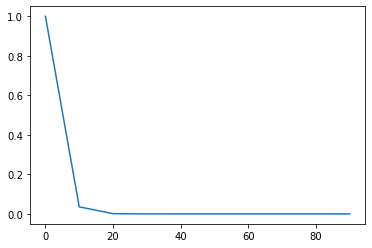

In [32]:
%%px
import matplotlib.pyplot as plt

%matplotlib inline

@bodo.jit
def dist_plot(n):
    X = np.arange(n)
    Y = np.exp(-X/3.0)
    plt.plot(X[::10], Y[::10]) # gather every 10th element
    plt.show()

dist_plot(100)

### Collections of Distributed Data
List and dictionary collections can be used to hold distributed data structures:

In [33]:
%%px

@bodo.jit()
def f():
    to_concat = []
    for i in range(10):
        to_concat.append(pd.DataFrame({'A': np.arange(100), 'B': np.random.random(100)}))
        df = pd.concat(to_concat)
    return df

f()

,A,B
0,0,0.666130
...,...,...
12,12,0.965744


,A,B
13,13,0.416815
...,...,...
25,25,0.895100


,A,B
26,26,0.539485
...,...,...
38,38,0.265940


,A,B
39,39,0.704682
...,...,...
51,51,0.417611


,A,B
52,52,0.318464
...,...,...
63,63,0.085373


,A,B
64,64,0.943277
...,...,...
75,75,0.527986


,A,B
76,76,0.134817
...,...,...
87,87,0.213622


,A,B
88,88,0.439429
...,...,...
99,99,0.106419


## Troubleshooting

### Compilation Tips

The general recommendation is to **compile the code that is performance critical and/or requires scaling**.

1. Don’t use Bodo for scripts that set up infrastucture or do initializations.
2. Only use Bodo for data processing and analytics code.

This reduces the risk of hitting unsupported features and reduces compilation time. To do so, simply factor out the code that needs to be compiled by Bodo and pass data into Bodo compiled functions.

### Compilation Errors

The most common reason is that the code relies on features that Bodo currently does not support, so it’s important to understand the limitations of Bodo. There are 4 main limitations:

1. Not supported Pandas API (see [here](https://docs.bodo.ai/2022.6/api_docs/pandas/))
2. Not supported NumPy API (see [here](https://docs.bodo.ai/2022.6/api_docs/numpy/))
3. Not supported Python features or datatypes (see [here](https://docs.bodo.ai/2022.6/bodo_parallelism/not_supported/))
4. Not supported Python programs due to type instability

Solutions:

1. Make sure your code works in Python (using a small sample dataset): a lot of the times a Bodo decorated function doesn’t compile, but it does not compile in Python either.
2. Replace unsupported operations with supported operations if possible.
3. Refactor the code to partially use regular Python, explained in "Integration with non-Bodo APIs" section.

For example, the code below uses heterogenous list values inside `a` which cannot be typed:

In [34]:
@bodo.jit
def f(n):
    a = [[-1, "a"]]
    for i in range(n):
        a.append([i, "a"])
    return a

print(f(3))

AssertionError: Failed in bodo mode pipeline (step: <class 'bodo.transforms.typing_pass.BodoTypeInference'>)


However, this use case can be rewritten to use tuple values instead of lists since values don't change:

In [35]:
@bodo.jit
def f(n):
    a = [(-1, "a")]
    for i in range(n):
        a.append((i, "a"))
    return a

print(f(3))

[(-1, 'a'), (0, 'a'), (1, 'a'), (2, 'a')]


### DataFrame Schema Stability

Deterministic dataframe schemas (column names and types), which are required in most data systems, are key for type stability. For example, variable `df` in example below could be either a single column dataframe or a two column one – Bodo cannot determine it at compilation time:

In [36]:
@bodo.jit
def f(a, n):
    df = pd.DataFrame({"A": np.arange(n)})
    df2 = pd.DataFrame({"A": np.arange(n) ** 2, "C": np.ones(n)})
    if len(a) > 3:
        df = df.merge(df2)

    return df.mean()

print(f([2, 3], 10))
# TypeError: Cannot unify dataframe((array(int64, 1d, C),), RangeIndexType(none), ('A',), False)
# and dataframe((array(int64, 1d, C), array(int64, 1d, C)), RangeIndexType(none), ('A', 'C'), False) for 'df'

TypingError: Failed in bodo mode pipeline (step: <class 'bodo.transforms.typing_pass.BodoTypeInference'>)
[1m[1mCannot unify dataframe((array(int64, 1d, C),), RangeIndexType(none), ('A',), 1D_Block_Var) and dataframe((array(int64, 1d, C), array(float64, 1d, C)), RangeIndexType(none), ('A', 'C'), 1D_Block_Var) for 'df.2', defined at /var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51280/1453791955.py (8)
[1m
File "../../../../../var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51280/1453791955.py", line 8:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m[0m[1mDuring: typing of assignment at /var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51280/1453791955.py (8)[0m
[1m
File "../../../../../var/folders/yz/bhxfdx_50rx1y003d175d_1h0000gn/T/ipykernel_51280/1453791955.py", line 8:[0m
[1m<source missing, REPL/exec in use?>[0m


The error message means that Bodo cannot find a type that can unify the two types into a single type. This code can be refactored so that the if control flow is executed in regular Python context, but the rest of computation is in Bodo functions. For example, one could use two versions of the function:

In [37]:
@bodo.jit
def f1(n):
    df = pd.DataFrame({"A": np.arange(n)})
    return df.mean()

@bodo.jit
def f2(n):
    df = pd.DataFrame({"A": np.arange(n)})
    df2 = pd.DataFrame({"A": np.arange(n) ** 2, "C": np.ones(n)})
    df = df.merge(df2)
    return df.mean()

a = [2, 3]
if len(a) > 3:
    print(f1(10))
else:
    print(f2(10))

A    3.5
C    1.0
dtype: float64


Another common place where schema stability may be compromised is in passing non-constant list of key column names to dataframe operations such as `groupby`, `merge` and `sort_values`. In these operations, Bodo should be able to deduce the list of key column names at compile time in order to determine the output dataframe schema. For example, the program below is potentially type unstable since Bodo may not be able to infer `column_list` during compilation:

In [38]:
@bodo.jit
def f(a, i, n):
    column_list = a[:i]  # some computation that cannot be inferred statically
    df = pd.DataFrame({"A": np.arange(n), "B": np.ones(n)})
    return df.groupby(column_list).sum()

a = ["A", "B"]
i = 1
f(a, i, 10)
# BodoError: groupby(): 'by' parameter only supports a constant column label or column labels.

,B
A,
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0


The code can most often be refactored to compute the key list in regular Python and pass as argument to Bodo:

In [39]:
@bodo.jit
def f(column_list, n):
    df = pd.DataFrame({"A": np.arange(n), "B": np.ones(n)})
    return df.groupby(column_list).sum()

a = ["A", "B"]
i = 1
column_list = a[:i]
f(column_list, 10)

,B
A,
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0


## Nullable Integers in Pandas

DataFrame and Series objects with integer data need special care due to [integer NA issues in Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#nan-integer-na-values-and-na-type-promotions). By default, Pandas dynamically converts integer columns to floating point when missing values (NAs) are needed, which can result in loss of precision as well as type instability.

Pandas introduced [a new nullable integer data type](https://pandas.pydata.org/pandas-docs/stable/user_guide/integer_na.html#integer-na) that can solve this issue, which is also supported by Bodo. For example, this code reads column A into a nullable integer array (the capital “I” denotes nullable integer type):

In [40]:
data = (
    "11,1.2\n"
    "-2,\n"
    ",3.1\n"
    "4,-0.1\n"
)

with open("data/data.csv", "w") as f:
    f.write(data)


@bodo.jit()
def f():
    dtype = {"A": "Int64", "B": "float64"}
    df = pd.read_csv("data/data.csv", dtype = dtype, names = dtype.keys())
    return df

f()

,A,B
0,11,1.2
1,-2,NaN
2,<NA>,3.1
3,4,-0.1


## Checking NA Values

When an operation iterates over the values in a Series or Array, type stablity requires special handling for NAs using `pd.isna()`. For example, `Series.map()` applies an operation to each element in the series and failing to check for NAs can result in garbage values propagating.

In [41]:
S = pd.Series(pd.array([1, None, None, 3, 10], dtype="Int8"))

@bodo.jit
def map_copy(S):
    return S.map(lambda a: a if not pd.isna(a) else None)

print(map_copy(S))

0       1
1    <NA>
2    <NA>
3       3
4      10
dtype: Int8


/Users/keatondrebes/Desktop/Work/Bodo/bodo/transforms/distributed_analysis.py:284: BodoWarning: No parallelism found for function 'map_copy'. Distributed diagnostics:

  warnings.warn(


### Boxing/Unboxing Overheads

Bodo uses efficient native data structures which can be different than Python. When Python values are passed to Bodo, they are *unboxed* to native representation. On the other hand, returning Bodo values requires *boxing* to Python objects. Boxing and unboxing can have significant overhead depending on size and type of data. For example, passing string column between Python/Bodo repeatedly can be expensive:

In [42]:
@bodo.jit()
def gen_data():
    df = pd.read_parquet("data/cycling_dataset.pq")
    df["hr"] = df["hr"].astype(str)
    return df

@bodo.jit()
def mean_power(df):
    x = df.hr.str[1:]
    return x

df = gen_data()
res = mean_power(df)
print(res)

0        1
1        2
2        2
3        3
4        3
        ..
3897    00
3898    00
3899    00
3900    00
3901    00
Name: hr, Length: 3902, dtype: object


One can try to keep data in Bodo functions as much as possible to avoid boxing/unboxing overheads:

In [43]:
@bodo.jit()
def gen_data():
    df = pd.read_parquet("data/cycling_dataset.pq")
    df["hr"] = df["hr"].astype(str)
    return df

@bodo.jit()
def mean_power(df):
    x = df.hr.str[1:]
    return x

@bodo.jit
def f():
    df = gen_data()
    res = mean_power(df)
    print(res)

f()

0        1
1        2
2        2
3        3
4        3
        ..
3897    00
3898    00
3899    00
3900    00
3901    00
Name: hr, Length: 3902, dtype: object


### Iterating Over Columns

Iterating over columns in a dataframe can cause type stability issues, since column types in each iteration can be different. Bodo supports this usage for many practical cases by automatically unrolling loops over dataframe columns when possible. For example, the example below computes the sum of all data frame columns:

In [44]:
@bodo.jit
def f():
    n = 20
    df = pd.DataFrame({"A": np.arange(n), "B": np.arange(n) ** 2, "C": np.ones(n)})
    s = 0
    for c in df.columns:
     s += df[c].sum()
    return s

f()

2680.0

For automatic unrolling, the loop needs to be a `for` loop over column names that can be determined by Bodo at compile time.

## Regular Expressions using `re`

Bodo supports string processing using Pandas and the `re` standard package, offering significant flexibility for string processing applications. For example:

In [45]:
import re

@bodo.jit
def f(S):
    def g(a):
        res = 0
        if re.search(".*AB.*", a):
            res = 3
        if re.search(".*23.*", a):
            res = 5
        return res

    return S.map(g)

S = pd.Series(["AABCDE", "BBABCE", "1234"])
f(S)

/Users/keatondrebes/Desktop/Work/Bodo/bodo/transforms/distributed_analysis.py:284: BodoWarning: No parallelism found for function 'f'. Distributed diagnostics:

  warnings.warn(


0    3
1    3
2    5
dtype: int64

## Class Support using `@jitclass`

Bodo supports Python classes using the @bodo.jitclass decorator. 
It requires type annotation of the fields, as well as distributed annotation where applicable. 
For example, the example class below holds a distributed dataframe of values and a name filed.
Types can either be specified directly using the imports in the bodo package or can
be inferred from existing types using `bodo.typeof`.

In [46]:
@bodo.jitclass(
    {
        "df": bodo.DataFrameType(
                (bodo.int64[::1], bodo.float64[::1]),
                bodo.RangeIndexType(bodo.none),
                ("A", "B"),
            ),
        "name": bodo.typeof("hello world"),
    },
    distributed=["df"],
)
class BodoClass:
    def __init__(self, n, name):
        self.df = pd.DataFrame({"A": np.arange(n), "B": np.ones(n)})
        self.name = name

    def sum(self):
        return self.df.A.sum()
    
    @property
    def sum_vals(self):
        return self.df.sum().sum()

    def get_name(self):
        return self.name

This JIT class can be used in regular Python code, as well as other Bodo JIT code.


In [47]:
# From a compiled function
@bodo.jit
def f():
    myInstance = BodoClass(32, "my_name_jit")
    return myInstance.sum(), myInstance.sum_vals, myInstance.get_name()

f()

(496, 528.0, 'my_name_jit')

In [48]:
# From regular Python
myInstance = BodoClass(32, "my_name_python")
myInstance.sum(), myInstance.sum_vals, myInstance.get_name()

(496, 528.0, 'my_name_python')